In [15]:
import pandas as pd
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.base import clone

from sklearn.metrics import accuracy_score, mean_squared_error, precision_score, recall_score, roc_auc_score, mean_absolute_error, f1_score

from explainer_comparison.ExplainerFactory import ExplainerFactory
from explainer_comparison.explainer_utilities import run_and_collect_explanations
from explainer_comparison.white_box_model.white_box import WhiteBoxRegressor
from explainer_comparison.explainers_evaluation import evaluate_explainers, permutation_feature_importance, plot_feat_importance
from explainer_comparison.constants import MODE


import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np


1. Feature Selection based measurement:
- divide the data to train, validation, and test sets
- train a RF model with basic hyperparameters (max_depth = 4, trees = 100) on the train set
- fit explainability method (each one separately).
- for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the form of "feature impact" (aggregation of all local feature impact).
- apply absolute value on the global explanation results to get the feature importance for each XAI method.
- sort the list to have the order of the least to the most important features.
- start an iterative process of eliminating the least important feature in each iteration and store the evaluation on the train, validation, and test sets (train will be store for reporting) - for classification store accuracy, precision, recall, auc. regression - MSE, MAE
- programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). you can do that by applying argmax operation. iteration here = number of features to eliminate.
- visualization: 
* each line represents the test score w.r.t each evaluation metric in each iteration. 
* the arg max is the displayed red vertical line in the following figure.
* print the final score- this is the score over the test set.
- after applying the process for each XAI method you should display the test score side by side

In [2]:
# read a dataset
df = pd.read_csv('../../data/diabetes/diabetes.csv')
# df = pd.read_csv('../../data/german_credit_score/german_credit.csv')

# random state
rs = 42

In [3]:
df.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


In [5]:
# data
X = df.iloc[:, :-1]

#target
y = df.Outcome

# - divide the data to train, validation, and test sets
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.5, shuffle=False, random_state=rs)
X_val, X_test, y_val, y_test = train_test_split(X_tmp, y_tmp, test_size=0.4, shuffle=False, random_state=rs)

X_train.shape, X_val.shape, X_test.shape

((384, 8), (230, 8), (154, 8))

In [6]:
# - train a RF model with basic hyperparameters (max_depth = 4, trees = 100) on the train set
model = RandomForestClassifier(max_depth=4, n_estimators=100, random_state=rs)
model.fit(X_train, y_train)


RandomForestClassifier(max_depth=4, random_state=42)

In [95]:
# - fit explainability method (each one separately).

# - for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the 
# form of "feature impact" (aggregation of all local feature impact).

# - apply absolute value on the global explanation results to get the feature importance for each XAI method.

# - sort the list to have the order of the least to the most important features.

# - start an iterative process of eliminating the least important feature in each iteration 
# and store the evaluation on the train, validation, and test sets (train will be store for reporting) - 
# for classification store accuracy, precision, recall, auc. regression - MSE, MAE

def evaluate_explainers(model, X_train, y_train, X_val, y_val, explainer, mode, threshold=0.2, random_state=None, verbose=True,): #metric='mse', 
    # Copy the data to avoid modifying the original
    current_X_train = X_train.copy()
    current_y_train = y_train.copy()
    current_X_val = X_val.copy()
    current_y_val = y_val.copy()
    current_model = model

    # clone the model to get unfitted model
    base_model = clone(model)

    # Get the list of column names
    columns = X_train.columns.tolist()
    n = len(columns)
    remaining_features = n * threshold

    # Initialize variables to store resuts
    res_list = []
    list_el_feats = []

    res_model_eval = []

    # evaluate the model
    current_model_results = evaluate_models(current_model, current_X_train, current_y_train, current_X_val, current_y_val, mode)
    res_model_eval.append(current_model_results)

    # Loop until the number of features is reduced to the desired threshold
    while len(columns) > remaining_features:

        if explainer == 'permutation':
            # # Calculate permutation feature importance
            current_importance_dict = permutation_feature_importance(current_model, current_X_train, random_state) # current_y, metric,
            current_importance = pd.DataFrame.from_dict(current_importance_dict, orient='index', columns=['importance'])
        
        else:
            # Get explainer values
            explainer_factory = ExplainerFactory(current_model, X_train=current_X_train, y_train=current_y_train)
            # shap_lime_importance = run_and_collect_explanations(explainer_factory, current_X)
            current_importance = run_and_collect_explanations(explainer_factory, current_X_train, verbose=verbose, explainers=explainer)

        # Find the least important feature
        # - apply absolute value on the global explanation results to get the feature importance for each XAI method.
        feature_importances = abs(current_importance)

        # - sort the list to have the order of the least to the most important features.
        sorted_feature_importances = feature_importances.sort_values(by=current_importance.columns[0], ascending=True)
        least_important_feature = sorted_feature_importances.index[0]

        
        # Print progress and results
        i = n - len(columns) + 1
        if verbose:
            print(f'\n {i} features eliminated. Now the least_important_feature is ', least_important_feature)


        # results = pd.concat([current_importance, feature_importances_df], axis=1)
        results = sorted_feature_importances

        ## add rows with 0 for eliminated features
        # if list_el_feats != []:
        #     for f in list_el_feats:
        #         results.loc[f] = [0] * results.shape[1]

        res_list.append(results)

        list_el_feats.append(least_important_feature)

        # Drop the least important feature
        current_X_train = current_X_train.drop(columns=[least_important_feature])
        current_X_val = current_X_val.drop(columns=[least_important_feature])
        columns.remove(least_important_feature)

        # Retrain the model with the reduced feature set
        current_model = base_model
        current_model.fit(current_X_train, current_y_train)

        # evaluate the model
        current_model_results = evaluate_models(current_model, current_X_train, current_y_train, current_X_val, current_y_val, mode)
        res_model_eval.append(current_model_results)

    # return a list of DataFrames with model evaluation results
    return res_list, res_model_eval


# # - start an iterative process of eliminating the least important feature in each iteration 
# and store the evaluation on the train, validation, and test sets (train will be store for reporting) 
# - for classification store accuracy, precision, recall, auc. regression - MSE, MAE
def evaluate_models(model, X_train, y_train, X_val, y_val, mode):
    res_dict, res_df = {}, None
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_val)
    train_tpl = (y_train, y_pred_train, 'train')
    val_tpl = (y_val, y_pred_val, 'val')

    for y, y_pred, name in [train_tpl, val_tpl]:

        if mode == MODE.CLASSIFICATION:
            res_dict['accuracy'] = accuracy_score(y, y_pred)
            res_dict['precision'] = precision_score(y, y_pred)
            res_dict['recall'] = recall_score(y, y_pred)
            res_dict['f1'] = f1_score(y, y_pred)
            res_dict['auc'] = roc_auc_score(y, y_pred)
        else:
            res_dict['mse'] = mean_squared_error(y, y_pred)
            res_dict['mae'] = mean_absolute_error(y, y_pred)

        tmp_res_df = pd.DataFrame.from_dict(res_dict, orient='index', columns=[name])
        
        if res_df is None:
            res_df = tmp_res_df
        else:
            res_df = pd.concat([res_df, tmp_res_df], axis=1)

    return res_df

# - programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). 
# you can do that by applying argmax operation. iteration here = number of features to eliminate.
def choose_best_feature_set(model_ev_results, main_metric = 'accuracy'):
    tdict = {}
    for metric in model_ev_results[0].index:
        metric_list = []
        for i in range(len(model_ev_results)):
            metric_list.append(model_ev_results[i].loc[[metric]]['train'].values[0])
        tdict[metric] = metric_list
    num_eliminated_feats = np.argmax(tdict[main_metric])

    fig, ax = plt.subplots(figsize=(8, 5))

    tdf = pd.DataFrame(tdict)

    tdf.plot(ax=ax)
    plt.axvline(x = num_eliminated_feats, color = 'r')

    plt.show()

    print(f'{num_eliminated_feats} features are suggested to be removed')
    print(model_ev_results[num_eliminated_feats])
    
    # return tdict


In [96]:
# - fit explainability method (each one separately).

# - for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the 
# form of "feature impact" (aggregation of all local feature impact).

# - apply absolute value on the global explanation results to get the feature importance for each XAI method.

# - sort the list to have the order of the least to the most important features.

# - start an iterative process of eliminating the least important feature in each iteration 
# and store the evaluation on the train, validation, and test sets (train will be store for reporting) - 
# for classification store accuracy, precision, recall, auc. regression - MSE, MAE
mode = MODE.CLASSIFICATION

results_feat_shap, results_model_shap = evaluate_explainers(model, X_train, y_train, X_val, y_val, 'shap', mode, threshold=0.3, random_state=42, verbose=False)
results_feat_lime, results_model_lime  = evaluate_explainers(model, X_test, y_test, X_val, y_val, 'lime', mode, threshold=0.3, random_state=42, verbose=False)
results_feat_permutation, results_model_permutation  = evaluate_explainers(model, X_test, y_test, X_val, y_val, 'permutation', mode, threshold=0.3, random_state=42, verbose=False)
results_feat_ebm, results_model_ebm  = evaluate_explainers(model, X_test, y_test, X_val, y_val, 'ebm', mode, threshold=0.3, random_state=42, verbose=False)

SHAP


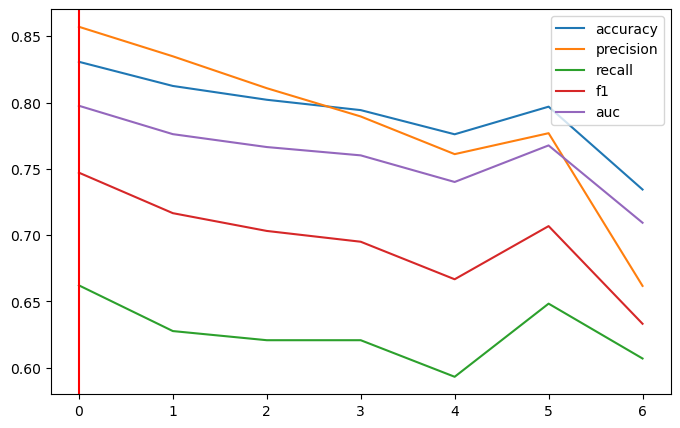

0 features are suggested to be removed
              train       val
accuracy   0.830729  0.821739
precision  0.857143  0.754717
recall     0.662069  0.588235
f1         0.747082  0.661157
auc        0.797562  0.753994

LIME


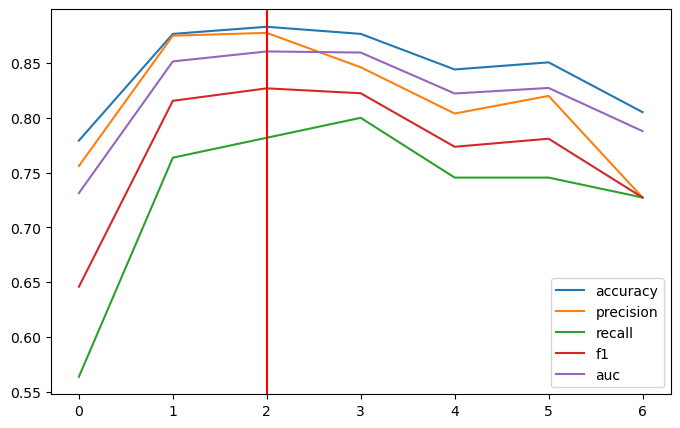

2 features are suggested to be removed
              train       val
accuracy   0.883117  0.682609
precision  0.877551  0.460317
recall     0.781818  0.426471
f1         0.826923  0.442748
auc        0.860606  0.608297

PERMUTATION


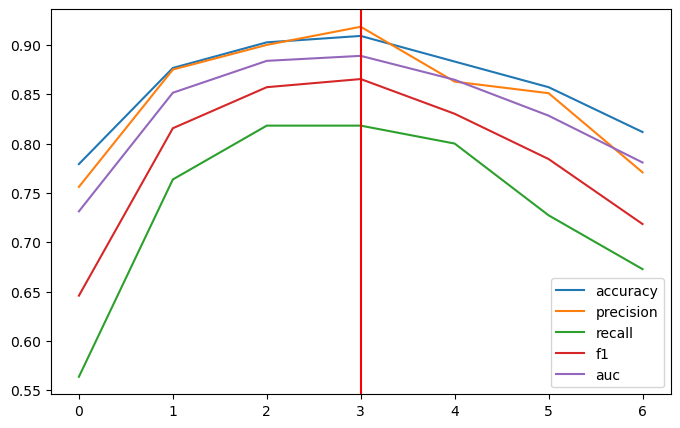

3 features are suggested to be removed
              train       val
accuracy   0.909091  0.800000
precision  0.918367  0.671875
recall     0.818182  0.632353
f1         0.865385  0.651515
auc        0.888889  0.751362

EBM


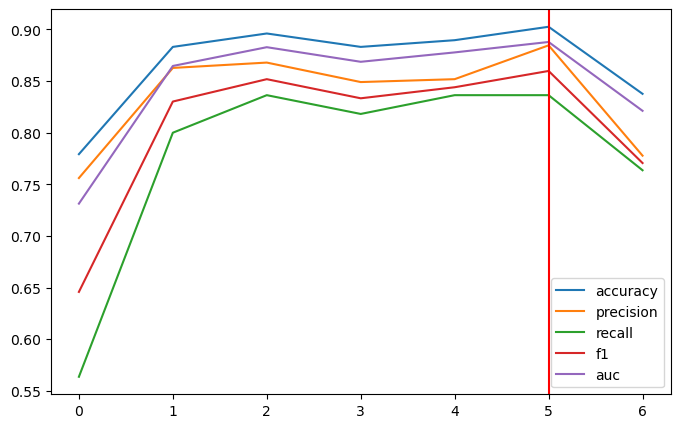

5 features are suggested to be removed
              train       val
accuracy   0.902597  0.765217
precision  0.884615  0.606061
recall     0.836364  0.588235
f1         0.859813  0.597015
auc        0.887879  0.713871


In [97]:
print('SHAP')
choose_best_feature_set(results_model_shap)
print()
print('LIME')
choose_best_feature_set(results_model_lime)
print()
print('PERMUTATION')
choose_best_feature_set(results_model_permutation)
print()
print('EBM')
choose_best_feature_set(results_model_ebm)

In [47]:

# - fit explainability method (each one separately).
# - for each explainability method (SHAP, LIME, Permutation, etc.) one should extract the global explanation in the form of "feature impact" (aggregation of all local feature impact).
# - apply absolute value on the global explanation results to get the feature importance for each XAI method.
# - sort the list to have the order of the least to the most important features.
# - start an iterative process of eliminating the least important feature in each iteration and store the evaluation on the train, validation, and test sets (train will be store for reporting) - for classification store accuracy, precision, recall, auc. regression - MSE, MAE
# - programmatically chose the best set of features based on a chosen evaluation metric (accuracy/ precision/ MSE...). you can do that by applying argmax operation. iteration here = number of features to eliminate.
# - visualization: 
# * each line represents the test score w.r.t each evaluation metric in each iteration. 
# * the arg max is the displayed red vertical line in the following figure.
# * print the final score- this is the score over the test set.
# - after applying the process for each XAI method you should display the test score side by side